In [1]:
import sys
sys.path.append('..')

In [2]:
import warnings
from collections import defaultdict
from pathlib import Path

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image, ImageDraw

from digi_leap.pylib import (
    db,
    label_transforms as lt,
    ocr_results,
)

In [3]:
# DATA = Path('..') / 'data' / 'sernec'
DATA = Path('..') / 'data' / 'label-babel-2'
SHEETS = DATA / 'sheets'
DB = DATA / 'label-babel-2.sqlite'

In [4]:
SHEETS = [dict(s) for s in db.select_sheets(DB)]

In [5]:
ocr = [dict(ocr) for ocr in db.select_ocr(DB)]
OCR = defaultdict(list)
for o in ocr:
    OCR[o['label_id']].append(o)

In [6]:
LABELS = [dict(lb) for lb in db.select_labels(DB) if lb['label_id'] in OCR]
LABELS = [lb for lb in LABELS if lb['class'] == 'Typewritten']
LABELS = sorted(LABELS, key=lambda lb: lb['label_id'])

len(LABELS)

15780

In [7]:
def get_label(idx):
    with warnings.catch_warnings():  # Turn off EXIF warnings
        warnings.filterwarnings("ignore", category=UserWarning)
        label = LABELS[idx]
        path = Path('..') / label['path']
        sheet = Image.open(path)
        image = sheet.crop((label["label_left"], label["label_top"],
                            label["label_right"], label["label_bottom"]))
        return label, image

In [8]:
def transform_label(label, image):
    trans = lt.transform_label('deskew', image)
    trans = trans.convert('RGB')
    return trans

In [9]:
COLORS = {
    ('deskew', 'tesseract'): 'red',
    ('deskew', 'easy'): 'blue',
    ('binarize', 'tesseract'): 'green',
    ('binarize', 'easy'): 'orange',
}


def display_boxes(ocr_boxes, image):
    draw = ImageDraw.Draw(image)

    for o in ocr_boxes:
        box = [o['left'], o['top'], o['right'], o['bottom']]
        color = COLORS[(o['pipeline'], o['engine'])]
        draw.rectangle(box, outline=color, width=2)

In [10]:
def trim_boxes(ocr_boxes, label):
    ocr = OCR[ocr_boxes['label_id']]

    for o in ocr:
        box = [o['left'], o['top'], o['right'], o['bottom']]
        box = label.crop(box)
        if box.size[0] == 0 or box.size[1] == 0:
            continue
        proj = iu.profile_projection(box)
        above = np.where(proj > 0)
        if above and len(above[0]) > 0:
            o['bottom'] = o['top'] + above[0][-1]
            o['top'] += above[0][0]

In [11]:
# SPELL = SpellChecker(distance=1)
# _WORDS = vocab.get_word_set(vocab.VOCAB_DIR / "plant_taxa.txt")
# SPELL.word_frequency.load_words(list(_WORDS))


# def misspellings(ln):
#     """Word misspellings."""
#     words = ln.split()

#     new = []
#     for word in words:
#         if vocab.in_any_vocab(word):
#             new.append(word)
#         else:
#             pre, suff = '', ''
#             if match := re.match(r'^\W+', word):
#                 pre = match.group(0)
#             if match := re.match(r'\W+$', word):
#                 suff = match.group(0)
#             base = word.removeprefix(pre).removesuffix(suff)
#             if not vocab.in_any_vocab(word) and len(base) > 2:
#                 cand = SPELL.candidates(base)
#                 print(f'{word=} {base=} {pre=} {suff=}')
#                 for c in cand:
#                     print(c)
#                 print()
#             new.append(word)

#     return ' '.join(new)

7
PLANTS OF PANAMA
Provlnce of PANAHA
Family: RUBIACEAE
eclate Sw.
Pet aboean-'
on road from
El Llano to Carti-Tupile. Alt. 200-500
Shrub to 3 meters; bracts shiny red within, outer
surface pink-purple; inner bracts red-orange;
corolla white; anthers black
Helen Kennedy 256
Date: 20-21ary 1973
Dutributed by the Miuouri Botanical Garden Herbarium (MO)


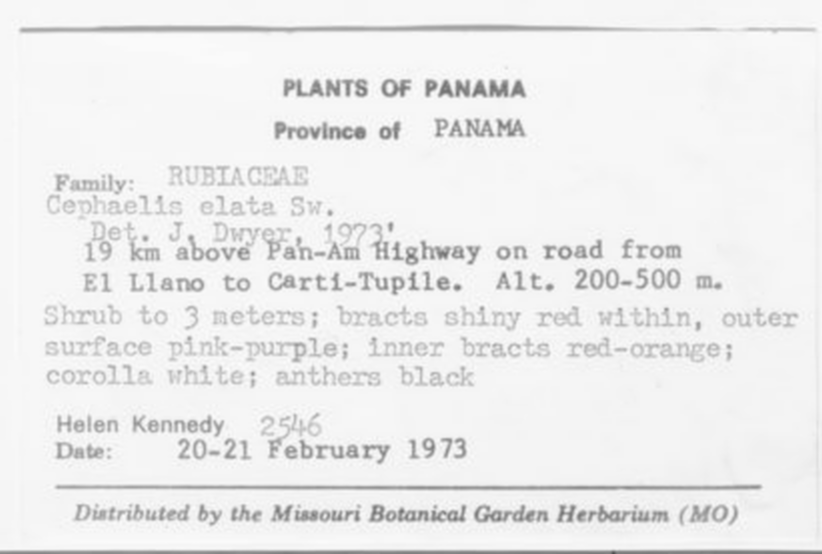

In [13]:
def build_ocr(idx):
    label, image = get_label(idx)
    print(label['label_id'])
    image = transform_label(label, image)
    ocr_boxes = OCR[label['label_id']]
    ocr_boxes = ocr_results.filter_boxes(ocr_boxes, image.size[1])
    # trim_boxes(ocr_boxes, label)
    # display_boxes(ocr_boxes, image)
    rows = ocr_results.get_lines(ocr_boxes)
    lines = []
    for row in rows:
        copies = ocr_results.get_copies(row)

        if len(copies) <= 1:
            continue

        copies = ocr_results.sort_copies(copies)

        aligned = ocr_results.align_copies(copies)
#         print('\n'.join(aligned))
#         print()

        cons = ocr_results.consensus(aligned)

        ln = ocr_results.substitute(cons)
        ln = ocr_results.spaces(ln)
#         ln = misspellings(ln)
        lines.append(ln)

    print('\n'.join(lines))
    display(image)


# interact(build_ocr, idx=(0, len(LABELS) - 1));
build_ocr(3)